久保拓弥『データ解析のための統計モデリング入門』をJuliaでやってみます。

* 久保さんの書籍ページ：http://hosho.ees.hokudai.ac.jp/~kubo/ce/IwanamiBook.html
* Amazon.co.jp：https://amzn.to/2Cg5vDJ

# 第4章 GLMのモデル選択 ---AICとモデルの予測の良さ---

In [12]:
using CSV
using DataFrames
using GLM
using Plots
using Distributions

## 4.1 データは一つ、モデルはたくさん（p.69）

In [13]:
d = CSV.read("data3a.csv");
fit1_1 = glm(@formula(y ~ 1), d, Poisson(), LogLink());
fit1_f = glm(@formula(y ~ f), d, Poisson(), LogLink());
fit1_x = glm(@formula(y ~ x), d, Poisson(), LogLink());
fit1_all = glm(@formula(y ~ x + f), d, Poisson(), LogLink());

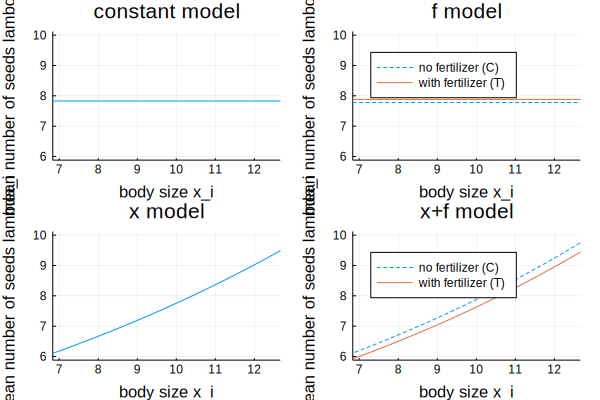

In [14]:
xx = range(5, stop=20, length=100)

# k=1 model
yy1 = predict(fit1_1)
plot(xx, yy1, layout=4, subplot=1, xlim=[7, 12.5], ylim=[6, 10], legend=false,
    xlabel="body size x_i", ylabel="mean number of seeds lambda_i", title="constant model")

# f model
yy1_C = predict(fit1_f, DataFrame(x=xx, f="C"))
yy1_T = predict(fit1_f, DataFrame(x=xx, f="T"))
plot!(xx, yy1_C, label="no fertilizer (C)", xlim=[7, 12.5], ylim=[6, 10], linestyle=:dash, legend=:topleft, subplot=2,
    xlabel="body size x_i", ylabel="mean number of seeds lambda_i", title="f model")
plot!(xx, yy1_T, label="with fertilizer (T)", subplot=2)

# x model
yy1 = predict(fit1_x, DataFrame(x=xx))
plot!(xx, yy1, xlim=[7, 12.5], ylim=[6, 10], legend=:topleft, subplot=3,
    label="", xlabel="body size x_i", ylabel="mean number of seeds lambda_i", title="x model")

# x+f model
yy1_C = predict(fit1_all, DataFrame(x=xx, f="C"))
yy1_T = predict(fit1_all, DataFrame(x=xx, f="T"))
plot!(xx, yy1_C, label="no fertilizer (C)", xlim=[7, 12.5], ylim=[6, 10], linestyle=:dash, legend=:topleft, subplot=4,
    xlabel="body size x_i", ylabel="mean number of seeds lambda_i", title="x+f model")
plot!(xx, yy1_T, label="with fertilizer (T)", subplot=4)

## 4.2 統計モデルのあてはまりの悪さ：逸脱度（p.71）

モデルへのデータの「あてはまりの悪さ」の指標として**逸脱度**（_deviance_）がある。対数尤度$\log L\left(\left\{\beta_j\right\}\right)$を最大化した最大対数尤度を$\log L^\ast$とすると、逸脱度$D$は以下のようになる。
$$ D = -2\log L^\ast $$

In [15]:
# 逸脱度（deviance）
D_1 = -2 * loglikelihood(fit1_1)
D_f = -2 * loglikelihood(fit1_f)
D_x = -2 * loglikelihood(fit1_x)
D_all = -2 * loglikelihood(fit1_all)
println(" 1  model: $(D_1)")
println("  f model: $(D_f)")
println("x   model: $(D_x)")
println("x+f model: $(D_all)")

 1  model: 475.28644261857346
  f model: 475.2545139213736
x   model: 470.77250153972153
x+f model: 470.5874384849874


In [16]:
# 残差逸脱度（residual deviance）..逸脱度からnull逸脱度（フルモデルの逸脱度＝最も低い逸脱度）を減算したもの
println(" 1  model: $(deviance(fit1_1))")
println("  f model: $(deviance(fit1_f))")
println("x   model: $(deviance(fit1_x))")
println("x+f model: $(deviance(fit1_all))")

 1  model: 89.50693756958142
  f model: 89.4750088723816
x   model: 84.9929964907296
x+f model: 84.8079334359953


ここで、nulldevianceを求めてみる。nulldevianceはフルモデルなので、応答変数`y`を説明変数で全て説明できるということになる。つまりモデル式は`y ~ y`でよいのかなと思ったら……

In [17]:
fit1_tmp = glm(@formula(y ~ y), d, Poisson(), LogLink())

StatsModels.DataFrameRegressionModel{GeneralizedLinearModel{GlmResp{Array{Float64,1},Poisson{Float64},LogLink},DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: y ~ 1 + y

Coefficients:
             Estimate Std.Error z value Pr(>|z|)
(Intercept)   1.03285  0.121459  8.5037   <1e-16
y            0.124078  0.013341 9.30045   <1e-19


In [18]:
loglikelihood(fit1_tmp)

-194.96897933244534

In [19]:
-2 * loglikelihood(fit1_tmp)

389.9379586648907

p.73図4.3には「最小の逸脱度385.8」とあるので、あとで脚注7を参照しながらやり直してみる。→と思ったら、p.74に答えが書いてあった。なるほど、各々のデータに最適なポアソン分布を与えてあげるのだから、そりゃ尤度が最高になる。

In [20]:
sum(log.(pdf.(Poisson.(d[:y]), d[:y])))

-192.889752524496

In [21]:
D_full = -2 * sum(log.(pdf.(Poisson.(d[:y]), d[:y])))

385.779505048992

In [22]:
println("x+f model: $(deviance(fit1_all))")
println("x+f model: $(D_all - D_full)")

x+f model: 84.8079334359953
x+f model: 84.80793343599538


モデル選択基準の一つとして**赤池情報量基準**（Akaike's Information Criterion）がある。これはモデルによる予測の良さ（goodness of prediction）を重視するとか。
$$ \mathrm{AIC} = -2\left\{\mathrm{最大対数尤度} - \mathrm{最尤推定したパラメータ数}\right\} = -2\left(\log L^\ast - k\right) = D + 2k $$

（対数尤度とパラメータ数は単位が違うのに単純に引き算しちゃってよいのだろうかと思ってしまう。どちらを重視するかといった按分パラメータが欲しい気もするが？　……というあたりの答えが次節にある）

----------
4.4節以降はプログラミング部分がないので省略。